test to plot PLATO LOPS field
with code sections from nplotcam.py of PLATO utilities ditro in github

In [1]:
# LOPS2plot
# Reads an ASCII table of targets and selects those within PLATO LOPS2 field, and plots in l,b and RA,Dec coordinates
# HJ Deeg 11 dec 2024, using code sections (target selection versus LOPS2-field and galactic projection) written by Pierre Maxted 
# 29 jan 2025: Added code to assign number of PLATO cameras (n_nom, n_min, n_max) to each target
# 19 mar 2025: Streamlined version that is easily adapted to other target lists
# 26 mar 2025: Updated credit to Pierre Maxted. rotation_angle for equatorial projection is now 13.99467 (value from Juan Cabrera). 
#              
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
#from astropy.coordinates import SkyCoord
from scipy.interpolate import RegularGridInterpolator
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
infile='RVstandards_soubiran13-table4.csv'  #example file with RV standards from Soubiran+ 2013, downloaded from VizieR 
tarlist = ascii.read(infile, format='csv', delimiter=';', fast_reader=False, comment='#')[2:]

#display(tarlist)

In [3]:

starcoord = SkyCoord(tarlist['_RA'], tarlist['_DE'], unit=(u.deg, u.deg))  # define as ra, dec coords
# first 5 entries of input table
#starcoord[0:5]

#convert to galactic coordinates
l=starcoord.galactic.l.degree   
b=starcoord.galactic.b.degree   
#starcoord[0:5].galactic   #first 5 entries in l,b


In [4]:
#import fits.gz file with PLATO field coordinates
#hdul = fits.open('nplatocamLOPS2.fits.gz')  #original fits.gz provided with nplatocam.py
hdul = fits.open('nplatocamLOPS2_2.fits.gz')  #nplatocamLOPS2_2.fits.gz : version with fixed reference of coord sys

hdu = hdul[0]
wcs = WCS(hdu.header)
xpxl = np.arange(hdu.header['NAXIS1'])
ypxl = np.arange(hdu.header['NAXIS2'])
map_nom = RegularGridInterpolator((xpxl,ypxl), hdu.data.T, method='nearest')
map_min = RegularGridInterpolator((xpxl,ypxl), hdul['NCAM_MIN'].data.T)
map_max = RegularGridInterpolator((xpxl,ypxl), hdul['NCAM_MAX'].data.T)
hdul.close()


In [5]:
# obtain the number of PLATO-cameras for each target
nstar=len(tarlist)
n_nom=np.zeros([nstar]) #nominal value for number of normal cameras
n_min=np.zeros([nstar]) #estimated minimum value for number of normal cameras
n_max=np.zeros([nstar]) #estimated maximum value for number of normal cameras
for i in range(nstar):    
    pxl = wcs.world_to_pixel_values(np.array([[l[i]],[b[i]]]).T)[0] 
    try:     
        n_nom[i] = map_nom(pxl)[0].astype(int)
        n_min[i] = np.floor(map_min(pxl)[0]).astype(int)
        n_max[i] = np.ceil(map_max(pxl)[0]).astype(int)
    except ValueError:
        n_nom[i], n_min[i], n_max[i] = 0,0,0
    #print(i, l[i], b[i], pxl[0], pxl[1], n_nom[i], n_min[i], n_max[i])

goodID=np.nonzero(n_nom)[0]  #targets inside LOPS2 
#goodID=np.nonzero(n_min)[0]  #targets inside LOPS2   
#badID=np.nonzero(n_nom==0)[0]  #targets that are outside LOPS2
edgeID=np.nonzero((n_min==0) & (n_max>3))[0]  #targets on the edge of LOPS2
tarlist['n_nom']=n_nom # add column with n_nom to tarlist
tarlist['n_min']=n_min # add column with n_min to tarlist
tarlist['n_max']=n_max # add column with n_max to tarlist
#len(badID)


In [6]:

LOPSonly=True   #set to True to keep only stars with n_nom>0. Set to False to plot and save the full input list
ntarorg=len(tarlist)
if LOPSonly:
    tarlist=tarlist[goodID]  #remove stars with n_nom=0; outcomment to keep all input targets
    starcoord=starcoord[goodID]  #remove stars with n_nom=0; outcomment to keep all input targets
    l=l[goodID]  #remove stars with n_nom=0; outcomment to keep all input targets
    b=b[goodID]  #remove stars with n_nom=0; outcomment to keep all input targets
ntar=len(tarlist)


Number of input targets: 1420 ; Number of targets in LOPS2: 83


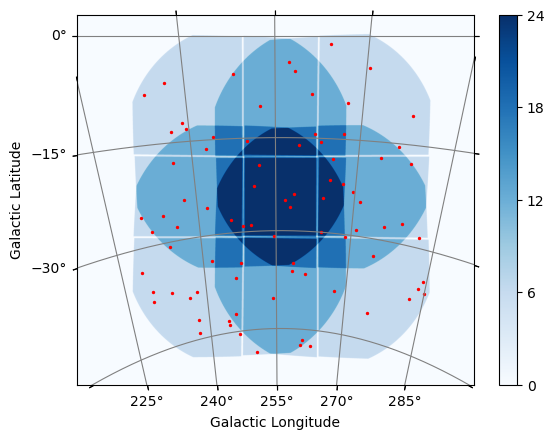

In [7]:

fig,ax=plt.subplots(subplot_kw={'projection':wcs})
pos = ax.imshow(hdu.data, origin='lower', cmap='Blues', aspect='auto')
ax.grid(color='gray', ls='solid')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
ax.scatter(l, b, transform=ax.get_transform('galactic'), color='r', s=2)#,label='TESS MMs')

#ax.scatter(l[goodID], b[goodID], transform=ax.get_transform('galactic'), color='r', s=2)#,label='TESS MMs in LOPS2')
#plt.legend()
cbar = fig.colorbar(pos, ax=ax, ticks=[0,6,12,18,24])
   
print('Number of input targets:',ntarorg,'; Number of targets in LOPS2:', ntar) 


In [8]:
from astropy.coordinates import SkyCoord, Galactic, ICRS
# Define the reference point in Galactic coordinates
galactic_ref = SkyCoord(l=wcs.wcs.crval[0] * u.deg,
                        b=wcs.wcs.crval[1] * u.deg,
                        frame=Galactic)

# Transform the reference point to Equatorial coordinates (ICRS)
equatorial_ref = galactic_ref.transform_to(ICRS)

# Create a new WCS object for Equatorial coordinates
wcs_equatorial = WCS(naxis=2)
wcs_equatorial.wcs.crpix = wcs.wcs.crpix
wcs_equatorial.wcs.cdelt = wcs.wcs.cdelt
wcs_equatorial.wcs.crval = [equatorial_ref.ra.deg, equatorial_ref.dec.deg]
wcs_equatorial.wcs.ctype = ["RA---TAN", "DEC--TAN"]

In [9]:
# Add a WCS rotation matrix 
rotation_angle = 13.99467 # inclination between coordinate systems at WCS point of reference
rotation_matrix = np.array([[np.cos(np.radians(rotation_angle)), -np.sin(np.radians(rotation_angle))],
                            [np.sin(np.radians(rotation_angle)), np.cos(np.radians(rotation_angle))]])

# Apply the rotation matrix to the WCS object
wcs_equatorial.wcs.pc = np.dot(wcs_equatorial.wcs.pc, rotation_matrix)

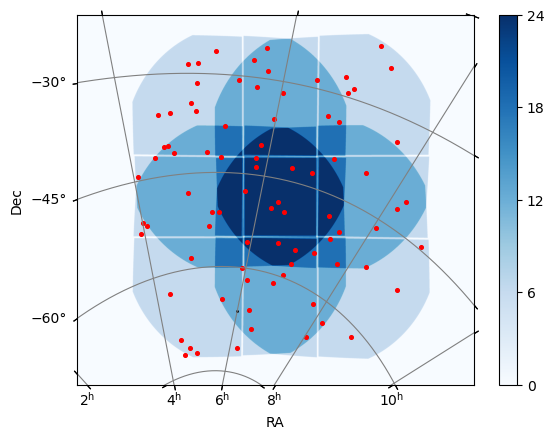

In [10]:
#plot field in ra, dec

fig,ax=plt.subplots(subplot_kw={'projection':wcs_equatorial})
pos = ax.imshow(hdu.data, origin='lower', cmap='Blues', aspect='auto')
ax.grid(color='gray', ls='solid')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')


ax.scatter(90, -66.5607, transform=ax.get_transform('icrs'), color='black', s=1)  # position of ecliptic pole
ax.scatter(starcoord.ra.deg, starcoord.dec.deg, transform=ax.get_transform('icrs'), color='r', s=7)#
#ax.scatter(starcoord[goodID].ra.deg, starcoord[goodID].dec.deg, transform=ax.get_transform('icrs'), color='r', s=2, label='TESS MMs in LOPS2')

ax.set_xlim(0, hdu.header['NAXIS1'])
ax.set_ylim(0, hdu.header['NAXIS2'])
cbar = fig.colorbar(pos, ax=ax, ticks=[0,6,12,18,24])
#plt.legend()

In [11]:

tarlist.write('RVstandards_LOPS2.csv', overwrite=True)